<a href="https://colab.research.google.com/github/fdmy2713-dotcom/MSc-in-Data-Science/blob/main/Farah_Dina_FDS_Student_Performance_Multiple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Student Performance Multiple Linear Regression**
*   Farah Dina_FDS_Student Performance Multiple Linear Regression.ipynb
*   Farah Dina
*   28 October 2025

### **Imports & Settings**

In [81]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import joblib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (8,5)

### **1. Load Dataset**

In [82]:
DATA_PATH = "Student_Performance.csv"
df = pd.read_csv(DATA_PATH)
# Number of Datapoints/Rows(10000) and Dimensions/Columns(6)
print("Dataset Loaded. Shape:", df.shape)
df.head()

Dataset Loaded. Shape: (10000, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91
1,4,82,No,4,2,65
2,8,51,Yes,7,2,45
3,5,52,Yes,5,2,36
4,7,75,No,8,5,66


### **2. Dataset Understanding**

In [83]:
# Display Columns and Data Types
print("\nColumns and Data Types:")

# Build a DataFrame showing name, dtype, and non-null count
columns_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.notnull().sum().values,
    'Missing Count': df.isnull().sum().values
})

display(columns_info)

print("\nBasic info:")
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")

# Results Information
# Students’ Records → 10,000
# 6 Attributes/Student → 5 Numbers, 1 Text Category
# No Missing Values


Columns and Data Types:


,Column Name,Data Type,Non-Null Count,Missing Count
0,Hours Studied,int64,10000,0
1,Previous Scores,int64,10000,0
2,Extracurricular Activities,object,10000,0
3,Sleep Hours,int64,10000,0
4,Sample Question Papers Practiced,int64,10000,0
5,Performance Index,int64,10000,0



Basic info:
Total Rows: 10000
Total Columns: 6


In [84]:
print("\nSummary Statistics for Numeric Features:")

# df.Describe → Generates Summary Statistics for the DataFrame columns (mean, std, min, max, quartiles, etc.)
# include=[np.number] → Limits the Summmary to Numeric Columns only
# .T → Transposes the Table to make it easier to read (each Feature becomes a row).
display(df.describe(include=[np.number]).T)

# df.duplicated() → Returns a Boolean Series (True/False) for each Row
# True → Row is a Duplicate
# False → Row is Unique
# .sum() → Adds up all the True values. Counts the Total Number of Duplicate Rows.
print("\nNumber of Duplicates:", df.duplicated().sum())

# Results Information
# count → Number of Rows with Data (non-missing) → 10,000
# mean → Average Value
# std → Standard Deviation
# min → Smallest Value
# 25% → 1st Quartile (25% of Data is below this).
# 50% → Median (Middle Value).
# 75% → 3rd Quartile (75% of Data is below this).
# max → Largest Value



Summary Statistics for Numeric Features:


,count,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Sleep Hours,10000.0,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0
Performance Index,10000.0,55.2248,19.212558,10.0,40.0,55.0,71.0,100.0



Number of Duplicates: 127


### **3. Quick Data Cleaning**

In [85]:
# 3.1 Check Missing Values

# .isnull()-->> Checks every cell in the dataset for missing values (NaN).
# Returns a DataFrame of the same shape filled with True (if missing) or False (if not missing).
# .sum()-->> When applied to a DataFrame of True/False, it counts how many True values (i.e., missing values) there are in each column.
# .sort_values(ascending=False)-->> Sorts the result so that columns with the most missing values appear first.
missing = df.isnull().sum().sort_values(ascending=False)

# missing[missing>0]-->> Sorts the result so that columns with the most missing values appear first.
print("\nMissing values per column:\n", missing[missing>0])

# Results Information
# Series([], dtype: int64) → An Empty Series, No Column has Missing Values
# Dataset is Complete, so Don’t Need to Fill or Drop Missing Data.


Missing values per column:
 Series([], dtype: int64)


In [86]:
# 3.2 Checks if Dataset has Duplicate Rows, and if so, it removes them and resets the index.

# df.duplicated()--> Returns a Boolean Series (True/False) for each row
# True → the row is a duplicate
# False → the row is unique
# .sum()--> Adds up all the True values. Counts the total number of duplicate rows.
if df.duplicated().sum() > 0:

    # df.drop_duplicates()-->> Removes all duplicate rows from the DataFrame, keeping only the first occurrence of each.
    # .reset_index(drop=True)-->> After dropping rows, the line resets the index back to 0, 1, 2, …
    df = df.drop_duplicates().reset_index(drop=True)

In [87]:
# Inspect Categorical Values for "Extracurricular Activities"
# Create a DataFrame from Value Counts
col = 'Extracurricular Activities'
value_counts_df = (df[col].value_counts(dropna=False).reset_index().rename(columns={'index': col, 'count': 'Count'}))
value_counts_df['Percentage (%)'] = (value_counts_df['Count'] / len(df) * 100).round(2)
print(f"\nValue counts for {col}:")
display(value_counts_df)


Value counts for Extracurricular Activities:


,Extracurricular Activities,Count,Percentage (%)
0,No,4986,50.5
1,Yes,4887,49.5


In [88]:
# 3.4 Convert Datatypes
# Converts the column “Hours Studied” into numeric values, and replaces any non-numeric or invalid data with NaN
df['Hours Studied'] = pd.to_numeric(df['Hours Studied'], errors='coerce')

### **4. Feature Engineering**

In [89]:
# Example derived features:
# - total_study_time (if multiple study columns exist)
# - is_extracurricular (binary)
# - parents_edu_level (map to numeric)
# Adjust this block to the dataset's actual column names.

# Example (replace with actual columns):
# if 'study_time' in df.columns and 'extra_study_time' in df.columns:
#     df['total_study_time'] = df['study_time'] + df['extra_study_time']

# Example binary indicator:
# if 'extracurricular' in df.columns:
#     df['is_extracurricular'] = df['extracurricular'].map({'yes':1,'no':0})


In [90]:
# Print resulting columns
print("\nColumns After (Planned) Feature Engineering:")
display(df.columns)


Columns After (Planned) Feature Engineering:


Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')

### **5. Exploratory Data Analysis (EDA)**

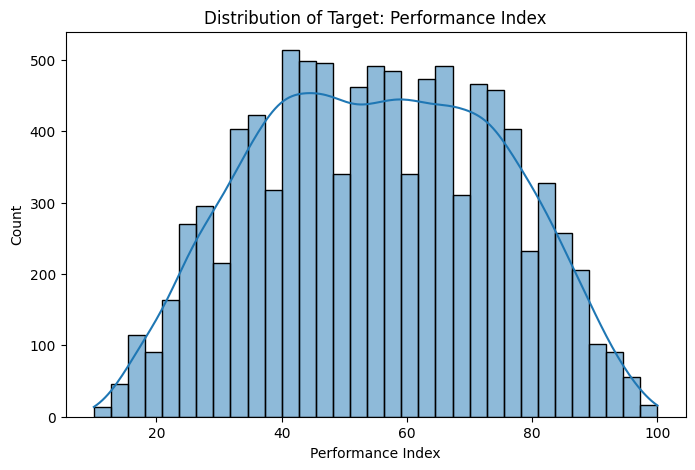

In [91]:
# 5.1 Distribution of Target Variable
TARGET = 'Performance Index'

# Histogram of Target
plt.figure()
plt.hist(df[TARGET].dropna(), bins=25, density=True, histtype='bar', rwidth=0.9, color='lightsteelblue')
sns.histplot(df[TARGET].dropna(), kde=True)
plt.title(f"Distribution of Target: {TARGET}")
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.show()

Candidate Study-Related Columns: ['Hours Studied']


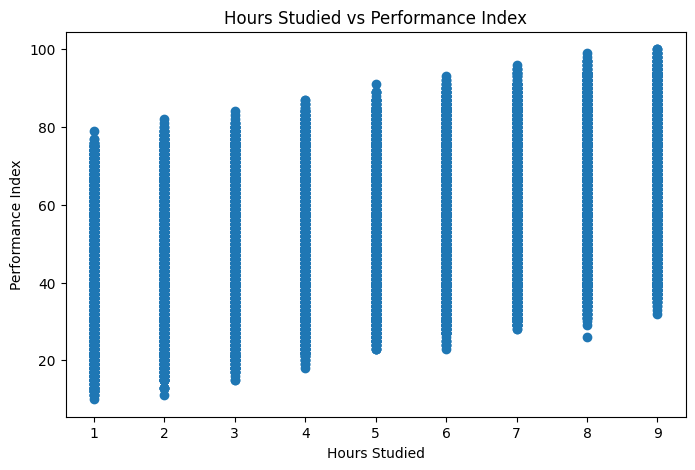

In [92]:
# 5.2 Relationship: study hours vs final score
# candidate_study_cols = [c for c in df.columns if 'study' in c.lower() or 'hour' in c.lower()]
candidate_study_cols = ['Hours Studied']
print("Candidate Study-Related Columns:", candidate_study_cols)

# plt.scatter(df[scol], df[TARGET]) → Creates a Scatter Plot
# each point represents a student,
# x-axis → How Many Hours They Studied
# y-axis → Their Score
if candidate_study_cols:
    scol = candidate_study_cols[0]
    plt.figure()
    plt.scatter(df[scol], df[TARGET])
    plt.xlabel(scol)
    plt.ylabel(TARGET)
    plt.title(f"{scol} vs {TARGET}")
    plt.show()

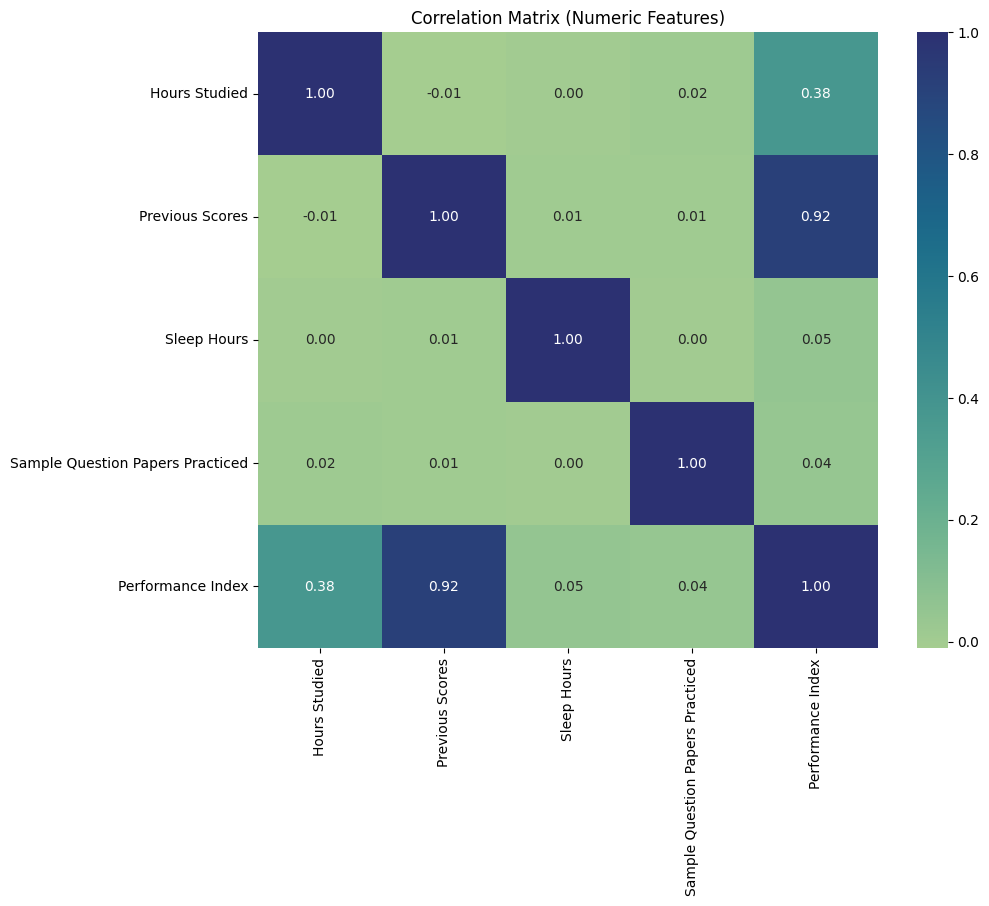


Top Numeric Correlations with Target:


,Feature,Correlation with Performance Index
0,Previous Scores,0.915135
1,Hours Studied,0.375332
2,Sleep Hours,0.050352
3,Sample Question Papers Practiced,0.043436


In [93]:
# 5.3.1 Correlation Matrix for Numeric Features
# Each Square Compares 2 Variables
# The Number Inside Square →  Correlation Coefficient → Ranges from -1 to +1

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='crest')
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

# 5.3.2 Print Top Correlations with TARGET
corr_with_target = (corr[TARGET].drop(TARGET).abs().sort_values(ascending=False))
corr_table = corr_with_target.head(10).reset_index()
corr_table.columns = ['Feature', f'Correlation with {TARGET}']
print("\nTop Numeric Correlations with Target:")
display(corr_table)

# Results Information
# 1. Previous Scores vs Performance Index = 0.92
# 1. Very Strong Positive Link → Past Performance is a Great Predictor of Final Performance, Students who Scored Well Before Continue to do Well
# 2. Hours Studied vs Performance Index = 0.37
# 2. Moderate Positive Link → Students Who Study More Tend to Perform Slightly Better
# 3. Sleep Hours vs Performance Index = 0.05
# 3. Almost No Relationship → Sleep Time Does Not Seem to Affect Scores Much
# 4. Sample Question Papers Practiced vs Performance Index = 0.04
# 4. Very Weak Link → Practicing Papers Does Not Show Much Direct Impact

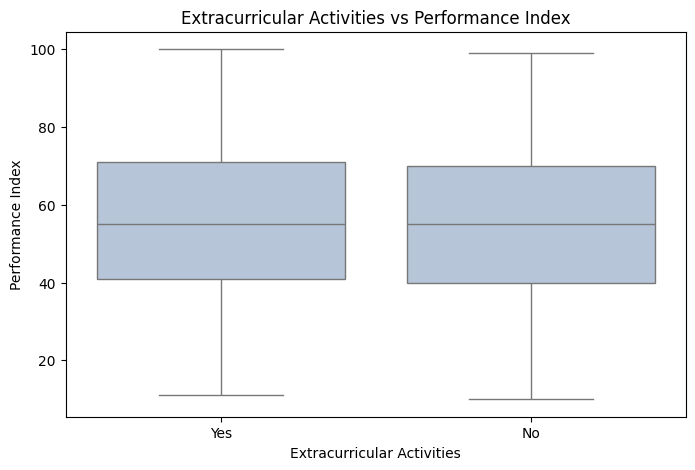


Summary statistics of Performance Index by Extracurricular Activities:


,Extracurricular Activities,count,mean,std,min,25%,50%,75%,max
0,No,4986.0,54.720818,19.146919,10.0,40.0,55.0,70.0,99.0
1,Yes,4887.0,55.722529,19.260073,11.0,41.0,55.0,71.0,100.0


In [94]:
# 5.4 Categorical vs Target (boxplots)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if cat_cols:
    for c in cat_cols[:4]:
        plt.figure()
        sns.boxplot(x=df[c], y=df[TARGET], fill=True, color='lightsteelblue')
        plt.title(f"{c} vs {TARGET}")
        plt.xticks(rotation=0)
        plt.show()

        print(f"\nSummary statistics of {TARGET} by {c}:")
        summary = df.groupby(c)[TARGET].describe().reset_index()
        display(summary)

### **6. Prepare Features for Modelling**

In [95]:
# Identify Numerical and Categorical Features
TARGET = 'Performance Index'
features = df.columns.drop([TARGET])
num_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
cat_features = df[features].select_dtypes(exclude=[np.number]).columns.tolist()

# Remove any potential empty strings or invalid entries from feature lists
num_features = [f for f in num_features if f and f in df.columns]
cat_features = [f for f in cat_features if f and f in df.columns]

print("\nFeature Type Summary:")

# Create a Combined DataFrame for Display
max_len = max(len(num_features), len(cat_features))
num_features_display = num_features + [''] * (max_len - len(num_features))
cat_features_display = cat_features + [''] * (max_len - len(cat_features))

features_table = pd.DataFrame({
    'Numeric Features': num_features_display,
    'Categorical Features': cat_features_display
})

display(features_table)


Feature Type Summary:


,Numeric Features,Categorical Features
0,Hours Studied,Extracurricular Activities
1,Previous Scores,
2,Sleep Hours,
3,Sample Question Papers Practiced,


In [96]:
# Simple imputation strategy
from sklearn.impute import SimpleImputer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

### **7. Split Data**

In [97]:
X = df[features]
y = df[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/Test Shapes:", X_train.shape, X_test.shape)

Train/Test Shapes: (7898, 5) (1975, 5)


### **8. Model 1: Multiple Linear Regression (Pipeline)**

In [98]:
# Linear Regression Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluation for Linear Regression
def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'R2': r2, 'MAE': mae, 'RMSE': rmse}

metrics_lr = regression_metrics(y_test, y_pred_lr)

# Cross-validated R² on training
cv_scores_lr = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='r2')

# Combine all results into a table
summary_lr = pd.DataFrame({
    'Metric': ['R² (Test Set)', 'MAE', 'RMSE', 'CV R² (mean)', 'CV R² (std)'],
    'Value': [
        metrics_lr['R2'],
        metrics_lr['MAE'],
        metrics_lr['RMSE'],
        cv_scores_lr.mean(),
        cv_scores_lr.std()
    ]
})

print("\nLinear Regression Evaluation Results:")
display(summary_lr)


Linear Regression Evaluation Results:


,Metric,Value
0,R² (Test Set),0.988430
1,MAE,1.646970
2,RMSE,2.075066
3,CV R² (mean),0.988717
4,CV R² (std),0.000315


### **9. Model 2: Random Forest Regression (Pipeline + Brief Tuning)**

In [104]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Simple param grid
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 6, 12],
    'regressor__min_samples_split': [2, 5]
}

# Combine all results into a table
summary_rf = pd.DataFrame({
    'Metric': ['R² (Test Set)', 'MAE', 'RMSE', 'CV R² (mean)', 'CV R² (std)', 'Best Params'],
    'Value': [
        metrics_rf['R2'],
        metrics_rf['MAE'],
        metrics_rf['RMSE'],
        cv_scores_rf.mean(),
        cv_scores_rf.std(),
        grid_rf.best_params_
    ]
})

print("\nRandom Forest Evaluation Results:")
display(summary_rf)



Random Forest Evaluation Results:


,Metric,Value
0,R² (Test Set),0.985773
1,MAE,1.837156
2,RMSE,2.301061
3,CV R² (mean),0.985924
4,CV R² (std),0.000501
5,Best Params,"{'regressor__max_depth': 12, 'regressor__min_s..."


### **10. Feature Importance & Interpretation**

In [107]:
# For Linear Regression: coefficients
# Get feature names from preprocessor pipeline
def get_feature_names(preprocessor):
    # Get output feature names from the preprocessor
    return preprocessor.get_feature_names_out()

feature_names = get_feature_names(lr_pipeline.named_steps['preprocessor'])
coefs = lr_pipeline.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(20)
print("\nTop Linear Regression Coefficients:")
display(coef_df)


Top Linear Regression Coefficients:


,feature,coef,abs_coef
1,num__Previous Scores,17.619931,17.619931
0,num__Hours Studied,7.373316,7.373316
2,num__Sleep Hours,0.802138,0.802138
3,num__Sample Question Papers Practiced,0.540053,0.540053
4,cat__Extracurricular Activities_No,-0.286911,0.286911
5,cat__Extracurricular Activities_Yes,0.286911,0.286911


In [116]:
# For Random Forest Regression
# Get feature names safely
def get_feature_names(pipeline):
    preprocessor = pipeline.named_steps['preprocessor']
    return preprocessor.get_feature_names_out()

# Compute permutation importance
perm = permutation_importance(
    best_rf, X_test, y_test,
    n_repeats=20, random_state=42, n_jobs=-1
)

# Align feature names correctly
feature_names = get_feature_names(best_rf)

# Ensure lengths match
print("Number of Features:", len(feature_names))
print("Number of Importances:", len(perm.importances_mean))

# Build DataFrame safely
importances = pd.DataFrame({
    'Feature': feature_names[:len(perm.importances_mean)],
    'Importance': perm.importances_mean
})

importances = importances.sort_values('Importance', ascending=False).head(20)

print("\nTop RF Permutation Importances:")
display(importances)


Number of Features: 6
Number of Importances: 5

Top RF Permutation Importances:


,Feature,Importance
1,num__Previous Scores,1.687679
0,num__Hours Studied,0.293100
3,num__Sample Question Papers Practiced,0.002798
4,cat__Extracurricular Activities_No,0.001652
2,num__Sleep Hours,0.000357


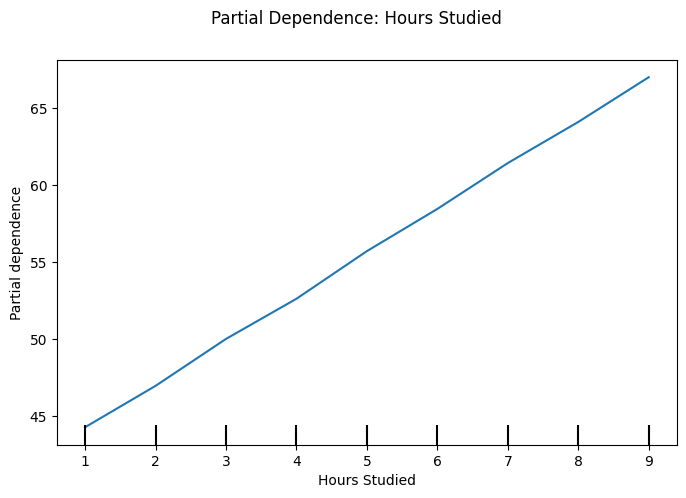

In [45]:
# Partial dependence for top numeric feature
top_num_feature = num_features[0] if num_features.size > 0 else None
if top_num_feature:
    fig, ax = plt.subplots()
    # Pass the original feature name to PartialDependenceDisplay
    PartialDependenceDisplay.from_estimator(best_rf, X_test, [top_num_feature], ax=ax)
    plt.suptitle(f"Partial Dependence: {top_num_feature}")
    plt.show()

### **11. Save Models**

In [46]:
joblib.dump(lr_pipeline, "Linear_Regression_Pipeline.pkl")
joblib.dump(best_rf, "Random_Forest_Pipeline.pkl")
print("Pipelines Saved to Disk.")

Pipelines Saved to Disk.


### **12. Summary Outputs**

In [113]:
# Create a combined DataFrame
summary_combined = pd.DataFrame({
    'Metric': ['R² (Test Set)', 'MAE', 'RMSE', 'CV R² (mean)', 'CV R² (std)'],
    'Linear Regression': [
        metrics_lr['R2'],
        metrics_lr['MAE'],
        metrics_lr['RMSE'],
        cv_scores_lr.mean(),
        cv_scores_lr.std()
    ],

    'Random Forest': [
        metrics_rf['R2'],
        metrics_rf['MAE'],
        metrics_rf['RMSE'],
        cv_scores_rf.mean(),
        cv_scores_rf.std()
    ]
})

print("\n Summary:Comparison of Linear Regression vs Random Forest:")
display(summary_combined)


 Summary:Comparison of Linear Regression vs Random Forest:


,Metric,Linear Regression,Random Forest
0,R² (Test Set),0.988430,0.985773
1,MAE,1.646970,1.837156
2,RMSE,2.075066,2.301061
3,CV R² (mean),0.988717,0.985924
4,CV R² (std),0.000315,0.000501


### **End of Notebook**